# Quantum Switch

## Contents

1. Quantum Swith
2. An Application of Quantum Switch: Parallel Processing

## 1. Quantum Switch
Quantum switch is a quantum cirtuit where the order of quantum operations is controlled by a quantum bit.

```
var x: quantum bit;
var f, g: quantum operation;

if x=1 then
  do -f-g-
else
  do -g-f-
```

In quantum switch, quantum operation f and g are parallelized.
- [Input 1] - f - [Output 2]
- [Input 3] - g - [Output 4]

If the control qubit is 1, quantum switch produces -f-g- by teleporting [Output 2] to [Input 3].
If the control qubit is 0, quantum switch produces -g-f- by teleporting [Output 4] to [Input 1].

This quantum teleportation moves a quantum state from future to past.
Therefore, quantum switch is not a determinstic cirtuit but a probabilistic circuit.

In [1]:
# import
import numpy as np
import itertools
from math import pi
import matplotlib.pyplot as plt

#%matplotlib inline

from qiskit import (
    QuantumCircuit,
    ClassicalRegister,
    QuantumRegister,
    execute,
    BasicAer,
    Aer,
    transpile,
    assemble,
)
from qiskit.visualization import plot_histogram, plot_bloch_multivector
from qiskit.quantum_info.operators import Operator
from qiskit.quantum_info import Statevector, partial_trace

print("Imports Successful")


Imports Successful


In [2]:
def calc_theta(p):
    return 2 * np.arccos(np.sqrt(p))


def fill_result(result):
    bit_len = len(list(result.keys())[0])
    bit = ["0", "1"]
    key_list = ["".join(bits) for bits in itertools.product(bit, repeat=bit_len)]

    total = sum(result.values())
    result_new = {}
    for k in key_list:
        v = result.get(k)
        result_new[k] = 0 if v is None else v / total
    return result_new


def count_result(result, filter_str):
    bit_list = []
    for bit_str in filter_str:
        if bit_str == "0" or bit_str == "1":
            bit_list.append([bit_str])
        else:
            bit_list.append(["0", "1"])
    key_list = ["".join(bits) for bits in itertools.product(*bit_list)]

    total = 0
    for k in key_list:
        total += result[k]

    return total


In [3]:
# Calculate probability where post-measurement state corresponds to bits.
def calcP(statevec, bits, with_statevec=False):
    proj = None
    for bit in bits:
        if bit==0:
            qb = Statevector([1, 0]).to_operator()
        elif bit==1:
            qb = Statevector([0, 1]).to_operator()
        else:
            qb = Operator([[1, 0], [0, 1]])
        proj = qb if proj is None else proj.tensor(qb)
    measure = statevec.evolve(proj)
    p = measure.inner(measure)
    if with_statevec:
        return p, measure
    else:
        return p

# Calculate post-measurement state.
def statevec_cond(statevec, bits):
    qargs = [n for n, v in enumerate(reversed(bits)) if v is not None]
    return partial_trace(statevec, qargs)

# Calculate probability and post-measurement state.
def statevec_mean_cond(statevector, bits):
    p, measure = calcP(statevector, bits, with_statevec=True)
    densitymatrix = statevec_cond(partial_trace(measure, []), bits)
    return p, densitymatrix/p

# Calculate probability and post-measurement state by sampling.
def statevec_mean_cond_sample(res, bits):
    nbit = len([v for v in bits if v is None])
    densitymatrix = None
    for bit in range(nbit):
        qb = Operator([[0, 0], [0, 0]])
        densitymatrix = qb if densitymatrix is None else densitymatrix.tensor(qb)
    count = 0
    for statevector in res:
        p = abs(calcP(statevector, bits))
        if p > 1 - 0.000000001:
            densitymatrix += statevec_cond(statevector, bits)
            count += 1
    return count*1.0/len(res), densitymatrix/count if count > 0 else None

In [4]:
def qswitch_g(qc, f, g, measure_flag=True):    
    qc.h(3)
    qc.cx(3,2)

    qc.barrier()
    
    qc.fredkin(0, 1, 2)
    qc.x(0)
    g(qc, 1)
    f(qc, 2)
    qc.fredkin(0, 1, 2)

    qc.barrier()

    qc.cx(2,3)
    qc.h(2)
    
    qc.barrier()

    if measure_flag:
        qc.measure(2, 0)
        qc.measure(3, 1)

    qc.barrier()
    
    return qc

def qswitch_qc(control_x, p_i, p_f, p_g, p_i2=pi/2, p_f2=pi/2, p_g2=pi/2, measure_flag=True, qs_measure_flag=True):  
    theta_i, phi_i, lmd_i = p_i, p_i2, p_i2
    theta_f, phi_f, lmd_f = p_f, p_f2, p_f2
    theta_g, phi_g, lmd_g = p_g, p_g2, p_g2
    def ini(qc, q):
        qc.u(theta_i, phi_i, lmd_i, q)
        
    def f(qc, q):
        qc.u(theta_f, phi_f, lmd_f, q)

    def g(qc, q):
        qc.u(theta_g, phi_g, lmd_g, q)

    def inv_ini(qc, q):
        qc.u(-theta_i, -phi_i, -lmd_i, q)

    def inv_f(qc, q):
        qc.u(-theta_f, -phi_f, -lmd_f, q)

    def inv_g(qc, q):
        qc.u(-theta_g, -phi_g, -lmd_g, q)

    # Initialize
    qc = QuantumCircuit(4, 3)
    if control_x == 1: # quantum switch conrtol
        qc.x(0)
    ini(qc, 1)
    qc.barrier()
    # quantum switch
    qswitch_g(qc, f, g, measure_flag=qs_measure_flag)
    # reverse
    if control_x == 1:
        inv_g(qc, 1)
        inv_f(qc, 1)
    else:
        inv_f(qc, 1)
        inv_g(qc, 1)

    inv_ini(qc, 1)
    
    if measure_flag:
        qc.measure(1, 2)

    return qc


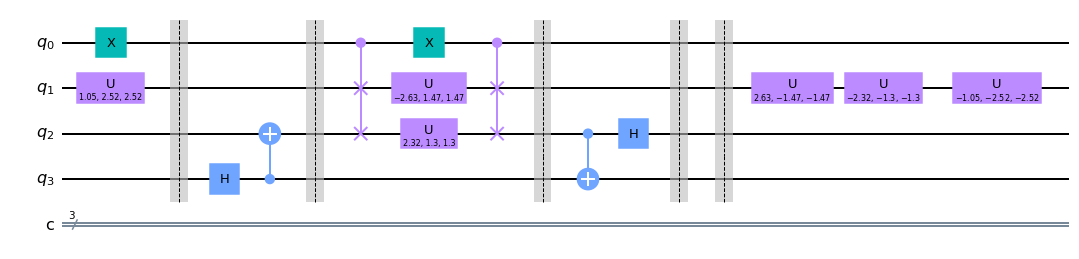

In [5]:
# This example produces a test circuit of quantum switch with a control qubit q0,
# input/output q1 and operator f and g.
# q2 and q3 are used for quantum teleportation.
# This circuit prepares the state of q1 by using an unitary operation (ini).
# And, this circuit performs the following operations to output q1 of the quantum switch.
# - inverted operations of f and g which order depends on the control qubit.
# - inverted operation of ini.
# Therefore, the final state of q1 becomes |0> if the quantum switch finishes successfully.
control_x = 1
not_control_x = ~control_x & 1
p_i, p_f, p_g = tuple((np.random.rand(3)-0.5)*2*pi)
p_i2, p_f2, p_g2 = tuple((np.random.rand(3)-0.5)*2*pi)
qc = qswitch_qc(control_x, p_i, p_f, p_g, p_i2=p_i2, p_f2=p_f2, p_g2=p_g2, measure_flag=False, qs_measure_flag=False)
qc.draw(output="mpl")

In [6]:
# The quantum switch measures output q2 and q3 of quantum teleportation
# and obtains one of four possible classical results. (00, 01, 10 and 11)
# If (q3, q2) = (0, 0), the quantum switch successfully finishes.
sv_simulator = Aer.get_backend('statevector_simulator')
circuit = transpile(qc, backend=sv_simulator)
statevector = sv_simulator.run(circuit).result().data()['statevector']

In [7]:
# This result shows the probability that (q3, q2) becomes (0, 0) is 0.25 and q1 = |0>.
# As a result, the quantum switch successfully finishes with probability 0.25.
statevec_mean_cond(statevector, [0, 0, None, not_control_x])

((0.24999999999999994+0j),
 DensityMatrix([[ 1.00000000e+00+0.00000000e+00j,
                 -5.55111512e-17-1.66533454e-16j],
                [-5.55111512e-17+1.66533454e-16j,
                  3.08148791e-32+0.00000000e+00j]],
               dims=(2,)))

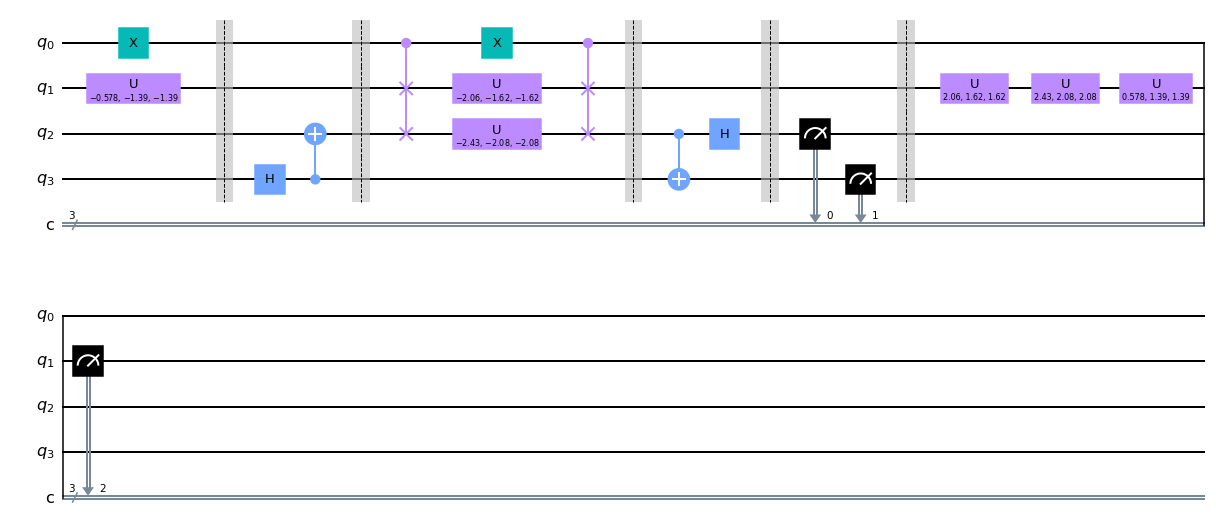

In [8]:
# Another simulation.
# This example measures q1, q3, q2.
control_x = 1
not_control_x = ~control_x & 1
p_i, p_f, p_g = tuple((np.random.rand(3)-0.5)*2*pi)
p_i2, p_f2, p_g2 = tuple((np.random.rand(3)-0.5)*2*pi)
qc = qswitch_qc(control_x, p_i, p_f, p_g, p_i2=p_i2, p_f2=p_f2, p_g2=p_g2, measure_flag=True, qs_measure_flag=True)
qc.draw(output="mpl")

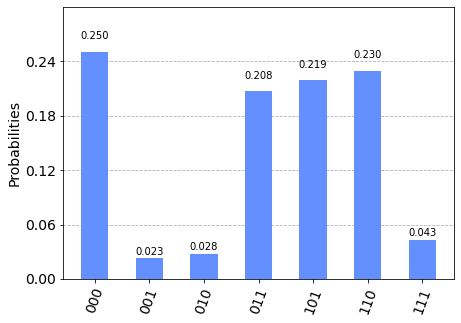

In [9]:
# This result shows that,
# - the probability that (q1, q3, q2) becomes (0, 0, 0) is about 0.25.
# - the probability that (q1, q3, q2) becomes (1, 0, 0) is 0.
# It means that the probability that (q3, q2) becomes (0, 0) is about 0.25 and q1 = |0>.
aer_sim = Aer.get_backend("aer_simulator")
job = aer_sim.run(assemble(qc), shots=4096)
result = job.result().get_counts()
plot_histogram(result)

## 2. An Application of Quantum Switch: Parallel Processing
This example produces a parallel processing circuit by using quantum switch.
In quantum switch, quantum operation f and f are parallelized.
- [Input 1] - f - [Output 2]
- [Input 3] - f - [Output 4]

This parallel processing circuit produces -f-f- by teleporting [Output 4] to [Input 1].
This example shows the success probability of parallel processing circuit is 0.5 in limited conditions while the success probability of quantum switch is 0.25.

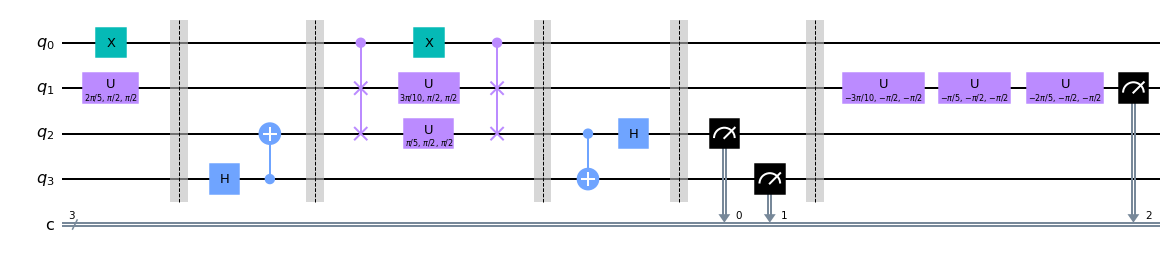

In [10]:
# This example assumes,
# - q1 = cos(theta1/2)|0> + exp(i*phi1)*sin(theta1/2)|1>
# - phi1 = pi/2
# - f = g = U(theta, phi, lambda).
# - phi = lambda = pi/2
control_x = 1
not_control_x = ~control_x & 1
p_i, p_f, p_g = (pi*0.4, pi*0.2, pi*0.3)
p_i2, p_f2, p_g2 = (pi/2, pi/2, pi/2)
qc = qswitch_qc(control_x, p_i, p_f, p_g, p_i2=p_i2, p_f2=p_f2, p_g2=p_g2, measure_flag=True, qs_measure_flag=True)
qc.draw(output="mpl")

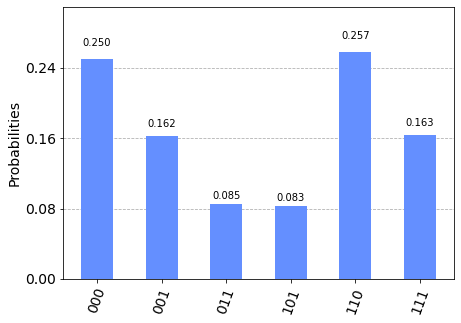

In [11]:
# This result shows that,
# - the probability that (q1, q3, q2) becomes (0, 0, 0) is about 0.25.
# - the probability that (q1, q3, q2) becomes (1, 0, 0) is 0.
# - the probability that (q1, q3, q2) becomes (0, 1, 0) is 0.
# - the probability that (q1, q3, q2) becomes (1, 1, 0) is about 0.25.
# It means that,
# - the probability that (q3, q2) becomes (0, 0) is about 0.25 and q1 = |0>.
# - the probability that (q3, q2) becomes (0, 1) is about 0.25 and q1 = |1>.
# As a result, the quantum switch successfully operates f^2 with probability 0.5 (not 0.25).
aer_sim = Aer.get_backend("aer_simulator")
job = aer_sim.run(assemble(qc), shots=4096)
result = job.result().get_counts()
plot_histogram(result)

In [12]:
def parallel_sim(p_i, p_f, p_i2, p_f2):
    control_x = 1
    not_control_x = ~control_x & 1
    p_g = p_f
    p_g2 = p_f2
    qc = qswitch_qc(control_x, p_i, p_f, p_g, p_i2=p_i2, p_f2=p_f2, p_g2=p_g2, measure_flag=False, qs_measure_flag=False)
    
    sv_simulator = Aer.get_backend('statevector_simulator')
    circuit = transpile(qc, backend=sv_simulator)
    statevector = sv_simulator.run(circuit).result().data()['statevector']
    
    p00, dmat00 = statevec_mean_cond(statevector, [0, 0, None, not_control_x])
    p10, dmat10 = statevec_mean_cond(statevector, [1, 0, None, not_control_x])
    prob = p00.real*np.sqrt(np.array(dmat00)[0][0].real) + p10.real*np.sqrt(np.array(dmat10)[1][1].real)
    return prob

def plot_parallel_sim_result_vs_theta(p_i2, p_f2):
    def get_parallel_sim_result(p_i):
        p_f_list = (np.linspace(0, 1, 11)-0.5)*2*pi
        prob = []
        for p_f in p_f_list:
            prob.append(parallel_sim(p_i, p_f, p_i2, p_f2))
        return p_f_list, prob
    
    p_i_list = (np.linspace(0, 1, 6)-0.5)*2*pi
    for p_i in p_i_list:
        p_f_list, prob = get_parallel_sim_result(p_i)
        plt.plot(p_f_list, prob, label=f"theta1={p_i:.1f}")
    plt.xlabel("theta of f")
    plt.ylabel("Prob")
    plt.ylim(0, 1)
    plt.yticks(np.linspace(0, 1, 11))
    plt.legend(bbox_to_anchor=(1.05, 1), loc="upper left", borderaxespad=0)

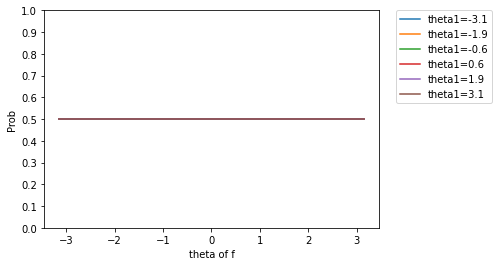

In [13]:
# Figure 1 shows the success probability of quantum switch with the following conditions.
# - theta1 = -pi .. pi
# - theta = -pi .. pi
# The quantum switch successfully operates f^2 with probability 0.5.
plot_parallel_sim_result_vs_theta(pi/2, pi/2)